[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PyPartMC/blob/main/examples/particle_simulation.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/particle_simulation.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/particle_simulation.ipynb)

In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2023 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from open_atmos_jupyter_utils import show_plot
import PyPartMC as ppmc
from PyPartMC import si

In [4]:
gas_data = ppmc.GasData(("H2SO4","HNO3","HCl","NH3","NO","NO2", "NO3",
                        "N2O5", "HONO", "HNO4", "O3", "O1D", "O3P", "OH",
                        "HO2", "H2O2", "CO", "SO2", "CH4", "C2H6", "CH3O2", 
                        "ETHP", "HCHO", "CH3OH", "ANOL", "CH3OOH", "ETHOOH",
                        "ALD2", "HCOOH", "RCOOH", "C2O3", "PAN", "ARO1", "ARO2",
                        "ALK1", "OLE1", "API1", "API2", "LIM1", "LIM2", "PAR", "AONE",
                        "MGLY", "ETH", "OLET", "OLEI", "TOL", "XYL", "CRES", "TO2",
                         "CRO", "OPEN", "ONIT", "ROOH", "RO2", "ANO2", "NAP", "XO2",
                         "XPAR", "ISOP", "ISOPRD", "ISOPP", "ISOPN", "ISOPO2", "API",
                         "LIM", "DMS", "MSA", "DMSO", "DMSO2", "CH3SO2H", "CH3SCH2OO", 
                         "CH3SO2", "CH3SO3", "CH3SO2OO", "CH3SO2CH2OO", "SULFHOX"
                        ))

In [5]:
env_state = ppmc.EnvState(
    {
        "rel_humidity": 0.95,
        "latitude": 0,
        "longitude": 0,
        "altitude": 0 * si.m,
        "start_time": 21600 * si.s,
        "start_day": 200,
    }
)

In [6]:
aero_data = ppmc.AeroData(
    (
        #         density  ions in soln (1) molecular weight    kappa (1)
        #         |                     |   |                   |
        {"SO4": [1800 * si.kg / si.m**3, 1, 96.0 * si.g / si.mol, 0.00]},
        {"NO3": [1800 * si.kg / si.m**3, 1, 62.0 * si.g / si.mol, 0.00]},
        {"Cl": [2200 * si.kg / si.m**3, 1, 35.5 * si.g / si.mol, 0.00]},
        {"NH4": [1800 * si.kg / si.m**3, 1, 18.0 * si.g / si.mol, 0.00]},
        {"MSA": [1800 * si.kg / si.m**3, 0, 95.0 * si.g / si.mol, 0.53]},
        {"ARO1": [1400 * si.kg / si.m**3, 0, 150.0 * si.g / si.mol, 0.10]},
        {"ARO2": [1400 * si.kg / si.m**3, 0, 150.0 * si.g / si.mol, 0.10]},
        {"ALK1": [1400 * si.kg / si.m**3, 0, 140.0 * si.g / si.mol, 0.10]},
        {"OLE1": [1400 * si.kg / si.m**3, 0, 140.0 * si.g / si.mol, 0.10]},
        {"API1": [1400 * si.kg / si.m**3, 0, 184.0 * si.g / si.mol, 0.10]},
        {"API2": [1400 * si.kg / si.m**3, 0, 184.0 * si.g / si.mol, 0.10]},
        {"LIM1": [1400 * si.kg / si.m**3, 0, 200.0 * si.g / si.mol, 0.10]},
        {"LIM2": [1400 * si.kg / si.m**3, 0, 200.0 * si.g / si.mol, 0.10]},
        {"CO3": [2600 * si.kg / si.m**3, 1, 60.0 * si.g / si.mol, 0.00]},
        {"Na": [2200 * si.kg / si.m**3, 1, 23.0 * si.g / si.mol, 0.00]},
        {"Ca": [2600 * si.kg / si.m**3, 1, 40.0 * si.g / si.mol, 0.00]},
        {"OIN": [2600 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.10]},
        {"OC": [1400 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.10]},
        {"BC": [1800 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.00]},
        {"H2O": [1000 * si.kg / si.m**3, 0, 18.0 * si.g / si.mol, 0.00]},
    )
)

In [7]:
gas_state = ppmc.GasState(gas_data)

input_gas_state = (
    {"NO": [0.1E+00]},
    {"NO2": [1.0E+00]},
    {"HNO3": [1.0E+00]},
    {"O3": [5.0E+01]},
    {"H2O2": [1.1E+00]},
    {"CO": [2.1E+02]},
    {"SO2": [0.8E+00]},
    {"NH3": [0.5E+00]},
    {"HCl": [0.7E+00]},
    {"CH4": [2.2E+03]},
    {"C2H6": [1.0E+00]},
    {"HCHO": [1.2E+00]},
    {"CH3OH": [1.2E-01]},
    {"CH3OOH": [0.5E+00]},
    {"ALD2": [1.0E+00]},
    {"PAR": [2.0E+00]},
    {"AONE": [1.0E+00]},
    {"ETH": [0.2E+00]},
    {"OLET": [2.3E-02]},
    {"OLEI": [3.1E-04]},
    {"TOL": [0.1E+00]},
    {"XYL": [0.1E+00]},
    {"ONIT": [0.1E+00]},
    {"PAN": [0.8E+00]},
    {"RCOOH": [0.2E+00]},
    {"ROOH": [2.5E-02]},
    {"ISOP": [0.5E+00]}
)

gas_state.mix_rats = input_gas_state

In [8]:
times = [0 * si.s]
back_gas = [{"time": times},
            {"rate": [1.5e-5 / si.s]},
            {"NO": [0.1E+00]},
            {"NO2": [1.0E+00]},
            {"HNO3": [1.0E+00]},
            {"O3": [5.0E+01]},
            {"H2O2": [1.1E+00]},
            {"CO": [2.1E+02]},
            {"SO2": [0.8E+00]},
            {"NH3": [0.5E+00]},
            {"HCl": [0.7E+00]},
            {"CH4": [2.2E+03]},
            {"C2H6": [1.0E+00]},
            {"HCHO": [1.2E+00]},
            {"CH3OH": [1.2E-01]},
            {"CH3OOH": [0.5E+00]},
            {"ALD2": [1.0E+00]},
            {"PAR": [2.0E+00]},
            {"AONE": [1.0E+00]},
            {"ETH": [0.2E+00]},
            {"OLET": [2.3E-02]},
            {"OLEI": [3.1E-04]},
            {"TOL": [0.1E+00]},
            {"XYL": [0.1E+00]},
            {"ONIT": [0.1E+00]},
            {"PAN": [0.8E+00]},
            {"RCOOH": [0.2E+00]},
            {"ROOH": [2.5E-02]},
            {"ISOP": [0.5E+00]}
           ]

gas_emit_times = [0, 3600, 7200, 10800, 14400, 18000, 21600, 25200, 28800, 32400, 36000,
                  39600, 43200, 46800, 50400, 54000, 57600, 61200, 64800, 68400, 72000,
                  75600, 79200, 82800, 90000, 93600, 97200, 100800, 104400, 108000]

gas_emit_rates = np.zeros(len(gas_emit_times))
gas_emit_rates[0:12] = .5

SO2 = [4.234E-09, 5.481E-09, 5.089E-09, 5.199E-09, 5.221E-09, 5.284E-09, 5.244E-09,
       5.280E-09, 5.560E-09, 5.343E-09, 4.480E-09, 3.858E-09, 3.823E-09, 3.607E-09,
       3.533E-09, 3.438E-09, 2.866E-09, 2.667E-09, 2.636E-09, 2.573E-09, 2.558E-09,
       2.573E-09, 2.715E-09, 3.170E-09, 4.2344E-09, 5.481E-09, 5.089E-09, 5.199E-09,
       5.221E-09, 5.284E-09]

NO2 = [3.024E-09, 3.334E-09, 3.063E-09, 3.281E-09, 3.372E-09, 3.523E-09, 3.402E-09,
       3.551E-09, 3.413E-09, 3.985E-09, 3.308E-09, 2.933E-09, 2.380E-09, 1.935E-09,
       1.798E-09, 1.537E-09 , 9.633E-10, 8.873E-10, 7.968E-10, 6.156E-10, 5.920E-10,
       6.320E-10, 9.871E-10, 1.901E-09, 3.024E-09, 3.334E-09, 3.063E-09, 3.281E-09,
       3.372E-09, 3.523E-09]

NO = [5.749E-08, 6.338E-08, 5.825E-08, 6.237E-08, 6.411E-08, 6.699E-08, 6.468E-08,
      6.753E-08, 6.488E-08, 7.575E-08, 6.291E-08, 5.576E-08, 4.524E-08, 3.679E-08,
      3.419E-08, 2.924E-08, 1.832E-08, 1.687E-08, 1.515E-08, 1.171E-08, 1.125E-08,
      1.202E-08, 1.877E-08, 3.615E-08, 5.749E-08, 6.338E-08, 5.825E-08, 6.237E-08,
      6.411E-08, 6.699E-08]

CO = [7.839E-07, 5.837E-07, 4.154E-07, 4.458E-07, 4.657E-07, 4.912E-07, 4.651E-07,
      4.907E-07, 6.938E-07, 8.850E-07, 8.135E-07, 4.573E-07, 3.349E-07, 2.437E-07,
      2.148E-07, 1.662E-07, 8.037E-08, 7.841E-08, 6.411E-08, 2.551E-08, 2.056E-08,
      3.058E-08, 1.083E-07, 3.938E-07, 7.839E-07, 5.837E-07, 4.154E-07, 4.458E-07,
      4.657E-07, 4.912E-07]

NH3 = [8.93E-09, 8.705E-09, 1.639E-08, 1.466E-08, 1.6405E-08, 1.8805E-08, 1.65E-08,
       1.8045E-08, 1.347E-08, 6.745E-09, 5.415E-09, 2.553E-09, 2.087E-09, 2.2885E-09,
       2.7265E-09, 2.7338E-09, 9.96E-10, 2.707E-09, 9.84E-10, 9.675E-10, 9.905E-10,
       1.0345E-09, 1.0825E-09, 2.7465E-09, 8.93E-09, 8.705E-09, 1.639E-08, 1.466E-08,
       1.6405E-08, 1.8805E-08]

HCHO = [4.061E-09, 3.225E-09, 2.440E-09, 2.639E-09, 2.754E-09, 2.888E-09, 2.741E-09,
        2.885E-09, 4.088E-09, 5.186E-09, 4.702E-09, 2.601E-09, 1.923E-09, 1.412E-09,
        1.252E-09, 9.776E-10, 4.687E-10, 4.657E-10, 3.836E-10, 1.717E-10, 1.448E-10,
        1.976E-10, 6.193E-10, 2.090E-09, 4.061E-09, 3.225E-09, 2.440E-09, 2.639E-09,
        2.754E-09, 2.888E-09]

ALD2 = [1.702E-09, 1.283E-09, 9.397E-10, 1.024E-09, 1.076E-09, 1.132E-09, 1.068E-09,
        1.130E-09, 1.651E-09, 2.132E-09, 1.985E-09, 1.081E-09, 7.847E-10, 5.676E-10,
        5.003E-10, 3.838E-10, 1.784E-10, 1.766E-10, 1.430E-10, 5.173E-11, 4.028E-11,
        6.349E-11, 2.428E-10, 8.716E-10, 1.7022E-09, 1.283E-09, 9.397E-10, 1.024E-09,
        1.076E-09, 1.132E-09]

ETH = [1.849E-08, 1.391E-08, 1.010E-08, 1.095E-08, 1.148E-08, 1.209E-08, 1.142E-08,
       1.205E-08, 1.806E-08, 2.320E-08, 2.149E-08, 1.146E-08, 8.384E-09, 6.124E-09,
       5.414E-09, 4.119E-09, 1.953E-09, 1.927E-09, 1.575E-09, 6.164E-10, 4.973E-10,
       7.420E-10, 2.653E-09, 9.477E-09, 1.849E-08, 1.391E-08, 1.010E-08, 1.095E-08,
       1.148E-08, 1.209E-08]

OLEI = [5.948E-09, 4.573E-09, 3.374E-09, 3.668E-09, 3.851E-09, 4.050E-09, 3.841E-09,
        4.052E-09, 6.094E-09, 7.795E-09, 7.215E-09, 3.738E-09, 2.718E-09, 1.973E-09,
        1.729E-09, 1.338E-09, 6.333E-10, 6.394E-10, 5.126E-10, 2.089E-10, 1.708E-10,
        2.480E-10, 8.947E-10, 3.057E-09, 5.948E-09, 4.573E-09, 3.374E-09, 3.668E-09,
        3.851E-09, 4.050E-09]

OLET = [5.948E-09, 4.573E-09, 3.374E-09, 3.668E-09, 3.851E-09, 4.050E-09, 3.841E-09,
        4.052E-09, 6.094E-09, 7.795E-09, 7.215E-09, 3.738E-09, 2.718E-09, 1.973E-09,
        1.729E-09, 1.338E-09, 6.333E-10, 6.394E-10, 5.126E-10, 2.089E-10, 1.708E-10,
        2.480E-10, 8.947E-10, 3.057E-09, 5.948E-09, 4.573E-09, 3.374E-09, 3.668E-09,
        3.851E-09, 4.050E-09]

TOL = [6.101E-09, 8.706E-09, 7.755E-09, 8.024E-09, 8.202E-09, 8.410E-09, 8.218E-09,
       8.407E-09, 1.020E-08, 1.139E-08, 7.338E-09, 4.184E-09, 3.078E-09, 2.283E-09,
       2.010E-09, 1.575E-09, 8.966E-10, 6.705E-10, 5.395E-10, 2.462E-10, 2.106E-10,
       2.852E-10, 9.300E-10, 3.144E-09, 6.101E-09, 8.706E-09, 7.755E-09, 8.024E-09,
       8.202E-09, 8.410E-09]

XYL = [5.599E-09, 4.774E-09, 3.660E-09, 3.909E-09, 4.060E-09, 4.239E-09, 4.060E-09,
       4.257E-09, 6.036E-09, 7.448E-09, 6.452E-09, 3.435E-09, 2.525E-09, 1.859E-09,
       1.650E-09, 1.302E-09, 6.852E-10, 6.773E-10, 5.437E-10, 2.697E-10, 2.358E-10,
       3.059E-10, 8.552E-10, 2.861E-10, 5.599E-09, 4.774E-09, 3.660E-09, 3.909E-09,
       4.060E-09, 4.239E-09]

AONE = [7.825E-10, 2.858E-09, 2.938E-09, 2.947E-09, 2.948E-09, 2.951E-09, 2.947E-09,
        2.954E-09, 3.032E-09, 2.766E-09, 1.313E-09, 1.015E-09, 8.363E-10, 7.040E-10,
        6.404E-10, 6.264E-10, 5.661E-10, 1.538E-10, 1.500E-10, 1.395E-10, 1.476E-10,
        1.503E-10, 2.256E-10, 4.244E-10, 7.825E-10, 2.858E-09, 2.938E-09, 2.947E-09,
        2.948E-09, 2.951E-09]

PAR = [1.709E-07, 1.953E-07, 1.698E-07, 1.761E-07, 1.808E-07, 1.865E-07, 1.822E-07,
       1.8599E-07, 2.412E-07, 2.728E-07, 2.174E-07, 1.243E-07, 9.741E-08, 7.744E-08,
       6.931E-08, 5.805E-08, 3.900E-08, 3.317E-08, 2.956E-08, 2.306E-08, 2.231E-08,
       2.395E-08, 4.284E-08, 9.655E-08, 1.709E-07, 1.953E-07, 1.698E-07, 1.761E-07,
       1.808E-07, 1.865E-07]

ISOP = [2.412E-10, 2.814E-10, 3.147E-10, 4.358E-10, 5.907E-10, 6.766E-10, 6.594E-10,
        5.879E-10, 5.435E-10, 6.402E-10, 5.097E-10, 9.990E-11, 7.691E-11, 5.939E-11,
        5.198E-11, 4.498E-11, 3.358E-11, 2.946E-11, 2.728E-11, 2.183E-11, 1.953E-11,
        1.890E-11, 2.948E-11, 1.635E-10, 2.412E-10, 2.814E-10, 3.147E-10, 4.358E-10,
        5.907E-10, 6.766E-10]

CH3OH = [2.368E-10, 6.107E-10, 6.890E-10, 6.890E-10, 6.890E-10, 6.889E-10, 6.886E-10,
         6.890E-10, 6.890E-10, 5.414E-10, 3.701E-10, 2.554E-10, 1.423E-10, 6.699E-11,
         2.912E-11, 2.877E-11, 2.825E-11, 2.056E-12, 2.056E-12, 2.056E-12, 2.435E-12,
         2.435E-12, 4.030E-11, 1.168E-10, 2.368E-10, 6.107E-10, 6.890E-10, 6.890E-10,
         6.890E-10, 6.889E-10]

ANOL = [5.304E-09, 7.960E-09, 7.649E-09, 7.649E-09, 7.432E-09, 7.428E-09,
        7.431E-09, 7.434E-09, 7.434E-09, 6.979E-09,5.666E-09, 4.361E-09, 4.148E-09,
        3.289E-09, 2.858E-09, 2.856E-09, 1.127E-09, 9.615E-10, 9.616E-10, 9.616E-10,
        9.654E-10, 9.654E-10, 1.397E-09, 2.264E-09, 5.304E-09, 7.960E-09, 7.649E-09,
        7.649E-09, 7.432E-09, 7.428E-09]

emit_gas = [
    {"time": gas_emit_times},
    {"rate": list(gas_emit_rates)},
    {"SO2": SO2},
    {"NO": NO},
    {"NO2": NO2},
    {"CO": CO},
    {"NH3": NH3},
    {"HCHO": HCHO},
    {"ALD2": ALD2},
    {"ETH": ETH},
    {"OLEI": OLEI},
    {"OLET": OLET},
    {"TOL": TOL},
    {"XYL": XYL},
    {"AONE": AONE},
    {"PAR": PAR},
    {"ISOP": ISOP},
    {"CH3OH": CH3OH},
    {"ANOL": ANOL},
]

AERO_DIST_BACKGROUND = {
    "back_small": {
        "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 3.2e9 / si.m**3,
        "geom_mean_diam": 0.02 * si.um,
        "log10_geom_std_dev": 0.161,
    },
    "back_large": {
        "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 2.9e9 / si.m**3,
        "geom_mean_diam": 0.16 * si.um,
        "log10_geom_std_dev": 0.217,
    },
}

AERO_DIST_EMIT = {
    "gasoline": {
        "mass_frac": [{"OC": [0.8]}, {"BC": [0.2]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 5e7 / si.m**3,
        "geom_mean_diam": 5e-8 * si.m,
        "log10_geom_std_dev": 0.24,
    },
    "diesel": {
        "mass_frac": [{"OC": [0.3]}, {"BC": [0.7]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 1.6e8 / si.m**3,
        "geom_mean_diam": 5e-8 * si.m,
        "log10_geom_std_dev": 0.24,
    },
    "cooking": {
        "mass_frac": [{"OC": [1]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 9e6 / si.m**3,
        "geom_mean_diam": 8.64e-8 * si.m,
        "log10_geom_std_dev": 0.28,
    },
}

In [9]:
time_timeseries = list(np.linspace(0,24*3600,25))
pressure_timeseries = list(np.ones(25) * 1e5)
temp_timeseries = [290.016,292.5, 294.5, 296.112, 297.649, 299.049, 299.684, 299.509,299.002,
                   298.432, 296.943, 295.153, 293.475, 292.466, 291.972, 291.96, 291.512,
                   291.481, 290.5,   290.313, 290.317, 290.362, 290.245, 290.228, 291.466]
height_timeseries = [171.045, 228.210, 296.987, 366.002, 410.868, 414.272, 417.807,414.133,
                     397.465, 376.864, 364.257, 352.119, 338.660, 322.028, 305.246, 258.497,  
                     240.478, 187.229, 145.851, 128.072, 110.679, 97.628, 93.034, 93.034, 93.034]

In [10]:
scenario = ppmc.Scenario(
    gas_data,
    aero_data,
    {
        "temp_profile": [{"time": time_timeseries}, {"temp": temp_timeseries}],
        "pressure_profile": [
            {"time": time_timeseries},
            {"pressure": pressure_timeseries},
        ],
        "height_profile": [{"time": time_timeseries}, {"height": height_timeseries}],
        "gas_emissions": emit_gas,
        "gas_background": back_gas,
        "aero_emissions": [
            {"time": [0 * si.s, 12 * 3600 * si.s]},
            {"rate": [1 / si.s, 0 / si.s]},
            {"dist": [[AERO_DIST_EMIT],[AERO_DIST_EMIT]]},
        ],
        "aero_background": [
            {"time": [0 * si.s]},
            {"rate": [1.5e-5 / si.s]},
            {"dist": [[AERO_DIST_BACKGROUND]]},
        ],
        "loss_function": "none",
    },
)

In [11]:
T_INITIAL = 0.0
scenario.init_env_state(env_state, T_INITIAL)

In [12]:
AERO_DIST_INIT = [
    {
        "init_small": {
            "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 3.2e9 / si.m**3,
            "geom_mean_diam": 0.02 * si.um,
            "log10_geom_std_dev": 0.161,
        },
        "init_large": {
            "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 2.9e9 / si.m**3,
            "geom_mean_diam": 0.16 * si.um,
            "log10_geom_std_dev": 0.217,
        },
    }
]

aero_dist_init = ppmc.AeroDist(aero_data, AERO_DIST_INIT)

In [13]:
run_part_opt = ppmc.RunPartOpt(
    {
        "output_prefix": "urban_plume",
        "do_coagulation": True,
        "coag_kernel": "brown",
        "do_parallel": False,
        "do_mosaic": False,
        "do_optical": False,
        "do_nucleation": False,
        "do_camp_chem": False,
        "do_condensation": False,
        "t_max": 86400 * si.s,
        "del_t": 60 * si.s,
        "t_output": 0,
        "t_progress": 0,
        "allow_halving": True,
        "allow_doubling": True,
        "rand_init": 0,
    }
)

N_PART = 1000
aero_state = ppmc.AeroState(aero_data, N_PART, 'nummass_source')
aero_state.dist_sample(
    aero_dist_init,
    sample_prop=1.0,
    create_time=0.0,
    allow_doubling=True,
    allow_halving=True,
)

1456

In [14]:
camp_core = ppmc.CampCore()
photolysis = ppmc.Photolysis()

In [15]:
N_STEPS = int(run_part_opt.t_max / run_part_opt.del_t)
num_conc = np.zeros(N_STEPS + 1)
num_conc[0] = aero_state.total_num_conc
mass_conc = np.zeros(N_STEPS + 1)
mass_conc[0] = aero_state.total_mass_conc
time = np.zeros(N_STEPS + 1)
gas_mix_rat = np.zeros((N_STEPS + 1, gas_state.n_spec))
gas_mix_rat[0, :] = gas_state.mix_rats

height = np.zeros((N_STEPS + 1))
temperature = np.zeros((N_STEPS + 1))
rh = np.zeros((N_STEPS + 1))

height[0] = env_state.height
temperature[0] = env_state.temp
rh[0] = env_state.rh

diam_grid = ppmc.BinGrid(30, "log", 1e-9, 1e-6)
dists = []
dry_diameters = aero_state.dry_diameters
num_concs = aero_state.num_concs
dists.append(ppmc.histogram_1d(diam_grid, dry_diameters, num_concs))

for i_time in range(1,N_STEPS + 1):
    ppmc.run_part_timestep(
        scenario,
        env_state,
        aero_data,
        aero_state,
        gas_data,
        gas_state,
        run_part_opt,
        camp_core,
        photolysis,
        i_time,
        T_INITIAL,
    )
    num_conc[i_time] = aero_state.total_num_conc
    mass_conc[i_time] = aero_state.total_mass_conc
    time[i_time] = env_state.elapsed_time
    gas_mix_rat[i_time, :] = gas_state.mix_rats
    height[i_time] = env_state.height
    temperature[i_time] = env_state.temp
    rh[i_time] = env_state.rh
    if np.mod(i_time * run_part_opt.del_t, 3600.0) == 0:
        dry_diameters = aero_state.dry_diameters
        num_concs = aero_state.num_concs
        dists.append(ppmc.histogram_1d(diam_grid, dry_diameters, num_concs))

In [16]:
plt.rcParams.update({'font.size': 9})
plt.rcParams.update({'figure.figsize': (3.08,2.5)})
plt.rcParams.update({"axes.grid" : True})

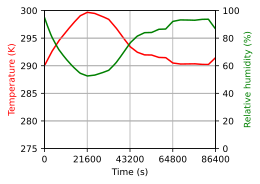

HTML(value="<a href='./tmpujsghx4s.pdf' target='_blank'>./tmpujsghx4s.pdf</a><br>")

In [17]:
plt.plot(time,temperature,'r')
plt.ylabel('Temperature (K)', color='r')
plt.ylim([275,300])
plt.xticks(np.linspace(0, time[-1], 5))
plt.xlim([0,time[-1]])
plt.xlabel('Time (s)')
plt.twinx()
plt.plot(time,rh*100,'g')
plt.ylabel('Relative humidity (%)', color='g')
plt.ylim([0,100])
show_plot()

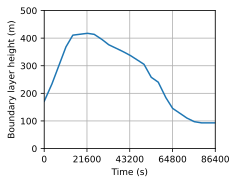

HTML(value="<a href='./tmpb59t04tj.pdf' target='_blank'>./tmpb59t04tj.pdf</a><br>")

In [18]:
plt.plot(time,height)
plt.xticks(np.linspace(0, time[-1], 5))
plt.xlim([0,time[-1]])
plt.xlabel('Time (s)')
plt.ylim([0,500])
plt.ylabel('Boundary layer height (m)')
show_plot()

In [19]:
def set_tickmarks(axes, n_ticks):
    ylims = axes.get_ylim()
    if np.log10(ylims[0]) > 1:
        val = -int(np.ceil(np.abs(np.log10(ylims[0])))) + 1
    else:
        val = int(np.ceil(np.abs(np.log10(ylims[0])))) + 1     
    ymin = round(ylims[0] - .1 * ylims[0], val)
    ymax = round(ylims[1] + .1 * ylims[1], val)
    plt.ylim([ymin, ymax])
    plt.yticks(np.linspace(ymin, ymax, n_ticks))

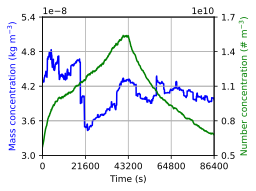

HTML(value="<a href='./tmp3dj0g9bs.pdf' target='_blank'>./tmp3dj0g9bs.pdf</a><br>")

In [20]:
plt.plot(time, mass_conc, "b", label="mass conc")
plt.ylabel("Mass concentration (kg m$^{-3}$)", color='b')
plt.xlabel("Time (s)")
set_tickmarks(plt.gca(), 5)
plt.twinx()
plt.plot(time, num_conc, "g", label="num conc")
plt.xticks(np.linspace(0, time[-1], 5))
plt.xlim([time[0],time[-1]])
set_tickmarks(plt.gca(), 5)
plt.ylabel(r"Number concentration ($\#$ m$^{-3}$)", color='g')
show_plot()

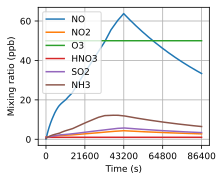

HTML(value="<a href='./tmpfplt3ibd.pdf' target='_blank'>./tmpfplt3ibd.pdf</a><br>")

In [21]:
gases = ["NO", "NO2", "O3", "HNO3", "SO2", "NH3"]
for i_spec, spec in enumerate(gases):
    i_spec = gas_data.spec_by_name(spec)
    l, = plt.plot(time, gas_mix_rat[:, i_spec], label=spec)
plt.xlabel("Time (s)")
plt.ylabel("Mixing ratio (ppb)")
plt.xticks(np.linspace(0, time[-1], 5))
plt.legend()
show_plot()

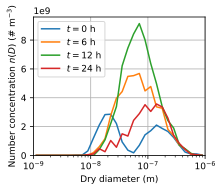

HTML(value="<a href='./tmp87frq60p.pdf' target='_blank'>./tmp87frq60p.pdf</a><br>")

In [22]:
plt.plot(diam_grid.centers, dists[0],label='$t = 0$ h')
plt.plot(diam_grid.centers, dists[6],label='$t = 6$ h')
plt.plot(diam_grid.centers, dists[12],label='$t = 12$ h')
plt.plot(diam_grid.centers, dists[24],label='$t = 24$ h')
plt.xscale("log")
plt.xlabel("Dry diameter (m)")
plt.ylabel(r"Number concentration $n(D)$ ($\#$ m$^{-3}$)")
plt.ylim(bottom=0)
plt.legend()
plt.xlim([diam_grid.edges[0],diam_grid.edges[-1]])
show_plot()

In [23]:
mass_frac_grid = ppmc.BinGrid(100, "linear", 0, 1)
mass_frac_histogram = []
num_concs = aero_state.num_concs
dry_diameters = aero_state.dry_diameters
species_mass_frac = np.zeros(len(aero_state))
species_index = aero_data.spec_by_name("BC")
for i_part in range(len(aero_state)):
    particle = aero_state.particle(i_part)
    masses = particle.species_masses
    species_mass_frac[i_part] = masses[species_index] / np.sum(masses[0:19])
vals = ppmc.histogram_2d(
    diam_grid, dry_diameters, mass_frac_grid, species_mass_frac, num_concs
)

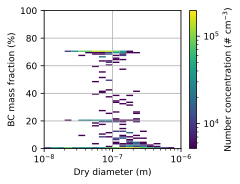

HTML(value="<a href='./tmpb6lfa259.pdf' target='_blank'>./tmpb6lfa259.pdf</a><br>")

In [24]:
plt.pcolormesh(
    diam_grid.edges,
    np.array(mass_frac_grid.edges)*100,
    np.array(vals).T / 1e6,
    norm=matplotlib.colors.LogNorm(),
)
plt.xscale("log")
plt.xlim([1e-8, 1e-6])
plt.colorbar(label=r"Number concentration ($\#$ cm$^{-3}$)")
plt.xlabel("Dry diameter (m)")
plt.ylabel("BC mass fraction (%)")
show_plot()